In [1]:
# Necessary imports
import pandas as pd
import numpy as np
from numpy import genfromtxt
import csv
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import time
import csv
from sklearn.impute import SimpleImputer as Imputer
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda, Input, Dense, Layer
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten 
from tensorflow.keras import backend as K
from numpy.random import seed
seed(1)
import random
random.seed(3)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score

C:\Users\91948\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Read the Secom dataset
reader = csv.reader(open("SECOM/SECOM.TXT"), delimiter=" ")
Data = pd.DataFrame(reader)
labels = csv.reader(open("SECOM/SECOM_labels.TXT"), delimiter=" ")
secom_labels = pd.DataFrame(labels)
y = secom_labels[0].astype('int8')
print("Data size",Data.shape)
print('Labels size',y.shape)
print("Minority class count =", np.sum(y==1))
print(Data.head())
Data.info()
#Data = Data.astype('float')
Target = pd.DataFrame()
Target['tar'] = y

Data size (1567, 590)
Labels size (1567,)
Minority class count = 104
       0        1          2          3       4    5         6       7    \
0  3030.93     2564  2187.7333  1411.1265  1.3602  100   97.6133  0.1242   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  100  102.3433  0.1247   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102  100   95.4878  0.1241   
3  2988.72   2479.9  2199.0333   909.7926  1.3204  100  104.2367  0.1217   
4  3032.24  2502.87  2233.3667    1326.52  1.5334  100  100.3967  0.1235   

      8        9    ...     580       581     582     583     584      585  \
0  1.5005   0.0162  ...     NaN       NaN  0.5005  0.0118  0.0035    2.363   
1  1.4966  -0.0005  ...   0.006  208.2045  0.5019  0.0223  0.0055   4.4447   
2  1.4436   0.0041  ...  0.0148   82.8602  0.4958  0.0157  0.0039   3.1745   
3  1.4882  -0.0124  ...  0.0044   73.8432   0.499  0.0103  0.0025   2.0544   
4  1.5031  -0.0031  ...     NaN       NaN    0.48  0.4766  0.1045  99.3032   

     

In [3]:
Data.shape

(1567, 590)

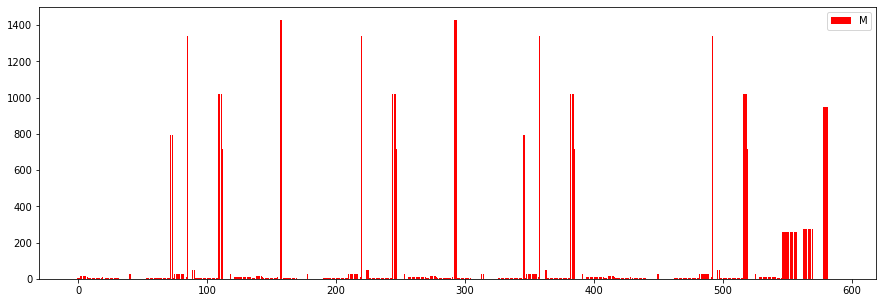

In [4]:
#Handling missing data
missdata_Columns = []
for i in Data.columns:
    if np.sum(Data[i][:] == 'NaN') >0:
        missdata_Columns.append([i,np.sum(Data[i][:] == 'NaN')])
        #print( i, ':',np.sum(Data[i][:] == 'NaN') )
        
missdata_df = pd.DataFrame(missdata_Columns)
plt.figure(figsize=(15,5))
plt.bar(missdata_df[0],missdata_df[1],color='red')
plt.legend('Missing')
#plt.savefig('SecomDatamissing.png')
#plt.show()

In [5]:
#Replace NaN in missing values with -1.0
Data = Data.replace(to_replace = 'NaN', value = '-1.0')
Datafloat = Data.copy()
#Convert to float datatype
Datafloat = Datafloat.astype('float64')

In [6]:
# Impute Missing Values
def impute(df, cols,strat):
    imputer = Imputer(missing_values = -1.0,strategy=strat)
    df_impute = df[cols]
    df[cols] = imputer.fit_transform(df_impute.values.reshape(-1,1))
    return df

In [7]:
#Imputing strategy mean, nearest and linear interpolation
for i in Datafloat.columns:
    if np.abs(np.sum(Datafloat[i][:] == -1.0)) >= 700:
        
        Datafloat.drop([i],inplace = True,axis =1)
    elif np.abs(np.sum(Datafloat[i][:] == -1.0)) <=30:
    #    print(i)
        600 #and np.abs(np.sum(Data[i][:] == -1.0)) <=780:
        Datafloat = impute(Datafloat,i,'mean')
    elif np.abs(np.sum(Datafloat[i][:] == -1.0))  > 30 and np.abs(np.sum(Datafloat[i][:] == -1))  <=200:
        Datafloat[i].replace(to_replace = -1.0, value = None)
        Datafloat[i].interpolate(method ='nearest', limit_direction ='forward')
    elif np.abs(np.sum(Datafloat[i][:] == -1.0))  > 200 and np.abs(np.sum(Datafloat[i][:] == -1))  <=300:
        Datafloat[i].replace(to_replace = -1.0, value = None)
        Datafloat[i].interpolate(method ='linear', limit_direction ='both')

In [8]:
#Get the unique value columns
def uniq_cols_fn(data):
    uniq_col_list = []
    for column in data.columns:
        if data[column].nunique() == 1:
            uniq_col_list.append(column)
    return uniq_col_list

In [9]:
len(uniq_cols_fn(Datafloat))

116

In [10]:
Datafloat = Datafloat.drop(axis=1, columns=uniq_cols_fn(Datafloat))
Datafloat.shape

(1567, 442)

In [11]:
np.sum(y==-1)

1463

In [12]:
#Normalize the data between +1 and -1
mmscaler    = MinMaxScaler(feature_range=(-1,1))
Datascaled   = mmscaler.fit_transform(Datafloat)

In [13]:
TrainDatascaled = Datascaled
y_trn = y

In [14]:
TrainDatascaled.shape

(1567, 442)

In [15]:
def metrics_aa_gm(ypred, ytrue):
    cm = confusion_matrix(ytrue, ypred)
    sum_classes = np.sum(cm, axis=1)
    true_pred = np.diagonal(cm)
    tp_rate = true_pred/sum_classes
    ACSA = np.mean(tp_rate)
    GM = np.sqrt(np.prod(tp_rate))
    return ACSA, GM

In [16]:
X_trainmlp, X_valmlp, y_trmlp, y_valmlp = train_test_split(TrainDatascaled, y_trn, 
                                                    test_size=0.3, random_state=1, stratify = y_trn)

##### SMOTE

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X_trainmlp, y_trmlp)

In [19]:
X_sm.shape

(2046, 442)

0.8535031847133758
              precision    recall  f1-score   support

    class -1       0.94      0.90      0.92       440
     class 1       0.15      0.26      0.19        31

    accuracy                           0.85       471
   macro avg       0.55      0.58      0.55       471
weighted avg       0.89      0.85      0.87       471



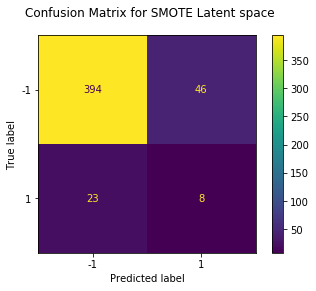

In [20]:
X_train = (X_sm)
y_train = (y_sm)
X_test = (X_valmlp)
y_test = (y_valmlp)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-2.85,2.85))

X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(batch_size =200,solver='sgd',hidden_layer_sizes=(512,256,64,16),
                    activation="tanh",learning_rate_init = 0.00352,random_state=1,shuffle = True,
                    max_iter = 5000,learning_rate = 'adaptive',beta_1=0.9,beta_2=0.999,
                   alpha=0.009,warm_start = False)
#learning_rate_init = 0.0000595
clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for SMOTE Latent space")
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [21]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print (acsa, gm,)

0.5767595307917889 0.4807130578508033


In [22]:
score_sm = silhouette_score(X_sm, y_sm, metric='l2')
print("Silhouette score for SMOTE oversampled data:")
print(score_sm)

Silhouette score for SMOTE oversampled data:
0.014541838607691256


##### No oversampling

0.910828025477707
              precision    recall  f1-score   support

    class -1       0.94      0.97      0.95       440
     class 1       0.18      0.10      0.12        31

    accuracy                           0.91       471
   macro avg       0.56      0.53      0.54       471
weighted avg       0.89      0.91      0.90       471



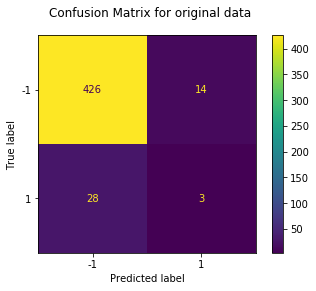

In [23]:
X_train = (X_trainmlp)
y_train = (y_trmlp)
X_test = (X_valmlp)
y_test = (y_valmlp)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-2.85,2.85))

X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(batch_size = 64,solver='sgd',hidden_layer_sizes=(512,256,64,16,),
                    activation="tanh",learning_rate_init = 0.00015,random_state=1,shuffle = True,
                    max_iter = 5000,learning_rate = 'adaptive',beta_1=0.9,beta_2=0.999,
                   alpha=0.009,warm_start = False)
#learning_rate_init = 0.0000595
clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for original data")
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [24]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print (acsa, gm,)

0.5324780058651026 0.3060964139985253


In [25]:
score_sm = silhouette_score(TrainDatascaled, y_trn, metric='l2')
print("Silhouette score for original data:")
print(score_sm)

Silhouette score for original data:
0.020299099322509614


##### ADASYN oversampling

In [26]:
from imblearn.over_sampling import ADASYN

In [27]:
oversample = ADASYN()
X_adsn, y_adsn = oversample.fit_resample(X_trainmlp, y_trmlp)

0.8407643312101911
              precision    recall  f1-score   support

    class -1       0.95      0.87      0.91       440
     class 1       0.18      0.39      0.24        31

    accuracy                           0.84       471
   macro avg       0.56      0.63      0.58       471
weighted avg       0.90      0.84      0.87       471



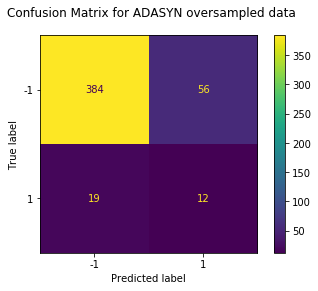

In [28]:
X_train = (X_adsn)
y_train = (y_adsn)
X_test = (X_valmlp)
y_test = (y_valmlp)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-2.85,2.85))

X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(batch_size =200,solver='sgd',hidden_layer_sizes=(512,256,64,16,),
                    activation="tanh",learning_rate_init = 0.00292,random_state=1,shuffle = True,
                    max_iter = 5000,learning_rate = 'adaptive',beta_1=0.9,beta_2=0.999,
                   alpha=0.009,warm_start = False)
#learning_rate_init = 0.0000595
clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for ADASYN oversampled data")
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [29]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print (acsa, gm,)

0.6299120234604105 0.5812313756357793


In [30]:
score_adsn = silhouette_score(X_adsn, y_adsn, metric='l2')
print("Silhouette score for adasyn oversampled data:")
print(score_adsn)

Silhouette score for adasyn oversampled data:
0.012669678443262842


##### Random oversampling

In [31]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_rand, y_rand = ros.fit_resample(X_trainmlp, y_trmlp)

0.7770700636942676
              precision    recall  f1-score   support

    class -1       0.95      0.80      0.87       440
     class 1       0.14      0.45      0.21        31

    accuracy                           0.78       471
   macro avg       0.55      0.63      0.54       471
weighted avg       0.90      0.78      0.83       471



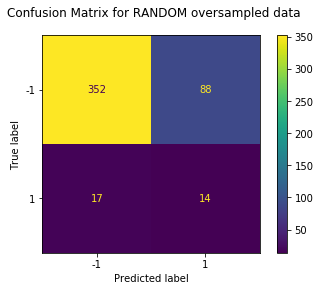

In [32]:
X_train = (X_rand)
y_train = (y_rand)
X_test = (X_valmlp)
y_test = (y_valmlp)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-2.85,2.85))

X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(batch_size =24,solver='adam',hidden_layer_sizes=(512,256,64,32,),
                    activation="tanh",learning_rate_init = 0.00192,random_state=1,shuffle = True,
                    max_iter = 5000,learning_rate = 'constant',beta_1=0.9,beta_2=0.999,
                   alpha=0.009,warm_start = False)
#learning_rate_init = 0.0000595
clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for RANDOM oversampled data")
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [33]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print (acsa, gm,)

0.6258064516129033 0.6010743070375286


In [34]:
score_rand = silhouette_score(X_rand, y_rand, metric='l2')
print("Silhouette score for RANDOM oversampled data:")
print(score_rand)

Silhouette score for RANDOM oversampled data:
0.009739406966287252


##### BORDERLINE SMOTE

In [35]:
from imblearn.over_sampling import BorderlineSMOTE
X_bos, y_bos = BorderlineSMOTE().fit_resample(X_trainmlp, y_trmlp)

0.7664543524416136
              precision    recall  f1-score   support

    class -1       0.95      0.79      0.86       440
     class 1       0.12      0.42      0.19        31

    accuracy                           0.77       471
   macro avg       0.54      0.61      0.53       471
weighted avg       0.90      0.77      0.82       471



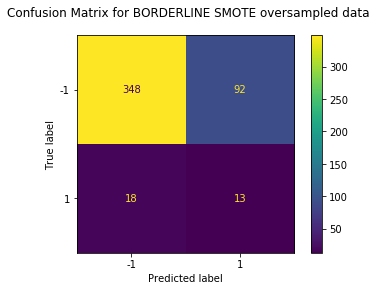

In [36]:
X_train = (X_bos)
y_train = (y_bos)
X_test = (X_valmlp)
y_test = (y_valmlp)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-2.85,2.85))

X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(batch_size = 200,solver='sgd',hidden_layer_sizes=(512,256,128,32,),
                    activation="tanh",learning_rate_init = 0.00192,random_state=1,shuffle = True,
                    max_iter = 5000,learning_rate = 'constant',beta_1=0.9,beta_2=0.999,
                   alpha=0.009,warm_start = False)
#learning_rate_init = 0.0000595
clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for BORDERLINE SMOTE oversampled data")
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [37]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print (acsa, gm,)

0.6051319648093841 0.5759093281517494


In [38]:
score_BOS = silhouette_score(X_bos, y_bos, metric='l2')
print("Silhouette score for Borderline SMOTE oversampled data:")
print(score_BOS)

Silhouette score for Borderline SMOTE oversampled data:
0.019016760758036728
